In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
from scipy.stats import qmc

from utils import *
from pinn import PINNs

/home/mukul/miniconda3/envs/PF/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# BS params
K = 4
sigma = 0.3
r = 0.03
T = 1
L = 10
N_x = 401
N_t = 401

In [3]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:1'

In [4]:
res_test, _, b_right_test, _, _ = get_test_data([0,10], [0,1], N_x, N_t)
# step_size = 1e-4
model = PINNs(in_dim=2, hidden_dim=256, out_dim=1, num_layer=6).to(device)
state = torch.load('BS_Put_PINNs_101')
model.load_state_dict(state['state_dict'])
model.eval()

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Tanh()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): Tanh()
    (10): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [5]:
N = norm.cdf

# res_test = make_time_sequence(res_test, num_step=5, step=step_size)
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
b_right_test = torch.tensor(b_right_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]
x_right_test, t_right_test = b_right_test[:,0:1], b_right_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred_right = model(x_right_test, t_right_test)[:,0:1]

    pred = pred.cpu().detach().numpy()
    pred_right = pred_right.cpu().detach().numpy()

pred = pred.reshape(N_x,N_t)
# print(pred_right.shape)
def BS_PUT(S, T):
    d1 = (np.log(np.where(S/K > 1e-8, S/K, 1e-8)) + (r + sigma**2/2)*T) / (sigma*np.sqrt(np.where(T > 1e-8, T, 1e-8)))
    d2 = d1 - sigma* np.sqrt(T)
    return K * np.exp(-r*T) * (1 - N(d2)) + S * (N(d1) - 1)

res_test, _, b_right_test, _, _ = get_test_data([0,10], [0,1], N_x, N_t)
u = BS_PUT(res_test[:,0], res_test[:,1]).reshape(N_x,N_t)
u_right = BS_PUT(b_right_test[:,0], b_right_test[:,1])

In [6]:
x_right_test.cpu().detach().numpy().shape, pred_right.shape

((401, 1), (401, 1))

In [9]:
u_right.shape, pred_right.shape

((401,), (401, 1))

In [8]:
rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

relative L1 error: 0.000707
relative L2 error: 0.000719


In [10]:
# At final time
rl1 = np.sum(np.abs(u_right-pred_right[:,0])) / np.sum(np.abs(u_right))
rl2 = np.sqrt(np.sum((u_right-pred_right[:,0])**2) / np.sum(u_right**2))

print('relative L1 error (At final time): {:4f}'.format(rl1))
print('relative L2 error (At final time): {:4f}'.format(rl2))

relative L1 error (At final time): 0.000519
relative L2 error (At final time): 0.000542


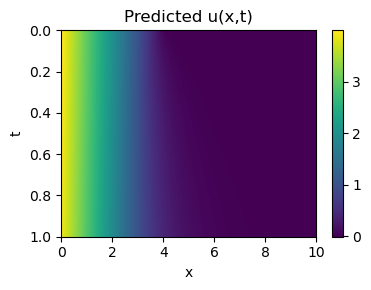

In [10]:
plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,10,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
# plt.savefig('./1dBS_Put_pinns_pred.png')

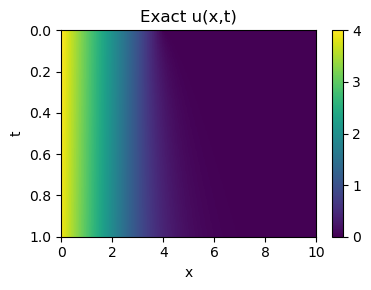

In [12]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,10,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
# plt.savefig('./1dBS_Put_pinns_pred.png')

(0.0, 0.001)

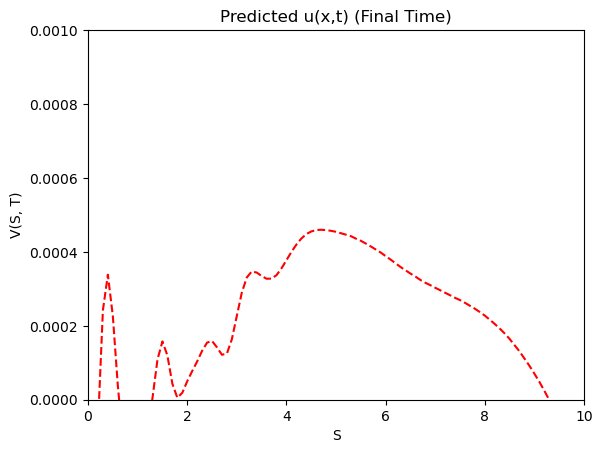

In [31]:
# Pointwise Error at final time

plt.figure()
plt.plot(x_right_test.cpu().detach().numpy()[:,0], u_right - pred_right[:,0], '--', color="r")
plt.xlabel('S')
plt.ylabel('V(S, T)')
plt.title('Predicted u(x,t) (Final Time)')
# set the limits
plt.xlim([0, 10])
plt.ylim([0, 0.001])
# plt.savefig('./1dBS_Put_PINNs_pointwise_error(Final Time).png')

In [13]:
# sampler = qmc.LatinHypercube(d=2)
# sample = sampler.random()

In [14]:
# x = np.random.uniform(*[0, 500], (10, 1))
# t = np.random.uniform(*[0,1], (10, 1))
# x_mesh, t_mesh = np.meshgrid(x,t)
# print(x_mesh.shape, t_mesh.shape)
# data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
# print(np.concatenate(x, np.zeros((10, 1)), axis=1))

# print(data[0,:,:])
# # print(data.reshape(-1,2)[:20,:])

# x = np.linspace(0, 500, 10)
# t = np.linspace(0, 1, 10)
# x_mesh, t_mesh = np.meshgrid(x,t)
# data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
# ub = data[:,-1,:]
# lb = data[:,0,:]
# print(lb)
# print(data.reshape(-1,2)[-12:,:])


In [15]:
# res, b_left, b_right, b_upper, b_lower = get_data([0,500], [0, 1], 10, 10)
# res_test, _, _, _, _ = get_data([0,10], [0,1], N_x, N_t)
# print(res.shape, b_left.shape, b_right.shape, b_upper.shape, b_lower.shape)
# res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
# b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
# b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
# b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
# b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)
# x_res, t_res = res[:,0:1], res[:,1:2]
# x_left, t_left = b_left[:,0:1], b_left[:,1:2]
# x_right, t_right = b_right[:,0:1], b_right[:,1:2]
# x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
# x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [16]:
model = PINNs(2, 256, 1, 6).to(device)
model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
n_params = get_n_params(model)

print(model)
print(get_n_params(model))

/tmp/ipykernel_1943228/122730209.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Tanh()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): Tanh()
    (10): Linear(in_features=256, out_features=1, bias=True)
  )
)
264193


In [26]:
pred_left = model(x_left, t_left)
pred_left.shape

torch.Size([101, 1])

In [17]:
loss_track = []
# K = torch.tensor(K, dtype=torch.float32, requires_grad=False).to(device)
# r = torch.tensor(r, dtype=torch.float32, requires_grad=False).to(device)
n_epochs = 10

for i in tqdm(range(n_epochs)):
  def closure():
    pred_res = model(x_res, t_res)
    pred_left = model(x_left, t_left)
    pred_right = model(x_right, t_right)
    pred_upper = model(x_upper, t_upper)
    pred_lower = model(x_lower, t_lower)

    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

    loss_res = torch.mean((u_t - ((sigma**2 * x_res**2) / 2) * u_xx - (r * x_res) * u_x + (r * pred_res)) ** 2)
    loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower - (K * torch.exp(-r * t_lower))) ** 2)
    loss_ic = torch.mean((pred_left[:,0] - torch.max(K - x_left[:,0], torch.zeros(x_left[:,0].shape).to(device))) ** 2)

    loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
    loss = loss_res + loss_ic + loss_bc
    optim.zero_grad()
    loss.backward()
    return loss

  optim.step(closure)
  if i % 2 == 0:
        print(f'{i}/{n_epochs} PDE Loss: {loss_track[-1][0]:.5f}, BVP Loss: {loss_track[-1][1]:.5f}, IC Loss: {loss_track[-1][2]:.5f},')

 10%|█         | 1/10 [00:15<02:20, 15.63s/it]

0/10 PDE Loss: 0.00363, BVP Loss: 0.03418, IC Loss: 0.00413,


 30%|███       | 3/10 [00:46<01:49, 15.61s/it]

2/10 PDE Loss: 0.00041, BVP Loss: 0.00897, IC Loss: 0.00033,


 50%|█████     | 5/10 [01:21<01:22, 16.53s/it]

4/10 PDE Loss: 0.00085, BVP Loss: 0.00531, IC Loss: 0.00084,


 70%|███████   | 7/10 [01:55<00:50, 16.94s/it]

6/10 PDE Loss: 0.00119, BVP Loss: 0.00286, IC Loss: 0.00009,


 90%|█████████ | 9/10 [02:29<00:16, 16.90s/it]

8/10 PDE Loss: 0.00039, BVP Loss: 0.00172, IC Loss: 0.00013,


100%|██████████| 10/10 [02:44<00:00, 16.48s/it]


In [18]:
res_test, _, b_right_test, _, _ = get_data([0,10], [0,1], N_x, N_t)
step_size = 1e-4

N = norm.cdf

# res_test = make_time_sequence(res_test, num_step=5, step=step_size)
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
b_right_test = torch.tensor(b_right_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]
x_right_test, t_right_test = b_right_test[:,0:1], b_right_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred_right = model(x_right_test, t_right_test)[:,0:1]

    pred = pred.cpu().detach().numpy()
    pred_right = pred_right.cpu().detach().numpy()

pred = pred.reshape(N_x,N_t)
print(pred_right.shape)

def BS_CALL(S, T):
    d1 = (torch.log(S/K) + (r + sigma**2 / 2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)
    return S * N(d1) - K * torch.exp(-r*T)* N(d2)

def BS_PUT(S, T):
    d1 = (np.log(np.where(S/K > 1e-8, S/K, 1e-8)) + (r + sigma**2/2)*T) / (sigma*np.sqrt(np.where(T > 1e-8, T, 1e-8)))
    d2 = d1 - sigma* np.sqrt(T)
    return K * np.exp(-r*T) * (1 - N(d2)) + S * (N(d1) - 1)

res_test, _, b_right_test, _, _ = get_data([0,10], [0,1], N_x, N_t)
u = BS_PUT(res_test[:,0], res_test[:,1]).reshape(N_x,N_t)
u_right = BS_PUT(b_right_test[:,0], b_right_test[:,1])

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

rl1_right = np.sum(np.abs(u_right-pred_right)) / np.sum(np.abs(u_right))
rl2_right = np.sqrt(np.sum((u_right-pred_right)**2) / np.sum(u_right**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

print('relative L1 error (final time): {:4f}'.format(rl1_right))
print('relative L2 error (final time): {:4f}'.format(rl2_right))


(750, 1)
relative L1 error: 0.010239
relative L2 error: 0.008847
relative L1 error (final time): 1037.019489
relative L2 error (final time): 31.494767


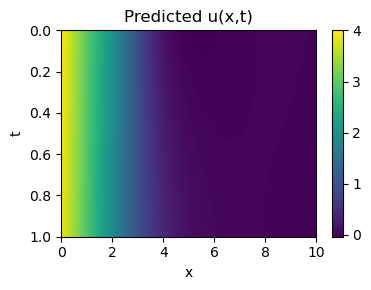

In [19]:
plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,10,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
# plt.savefig('./1dBS_Put_pinnsformer_pred.png')
plt.show()


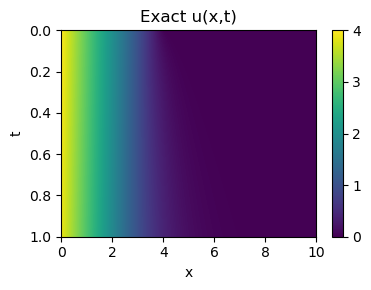

In [20]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,10,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
# plt.savefig('./1dBS_Put_exact.png')
plt.show()

In [30]:
print(pred.reshape((-1,1))[:,0].shape)
x_test.cpu().detach().numpy()[:,0].shape

(562500,)


(562500,)

<function matplotlib.pyplot.show(close=None, block=None)>

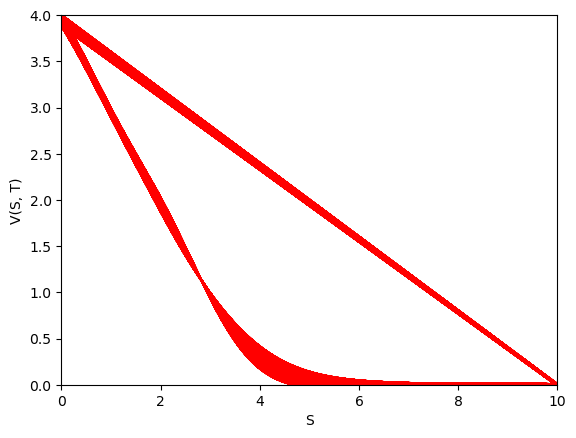

In [29]:
# plt.plot(X[final_index, 0], y_pred[final_index], '--', color="r")
plt.plot(x_test.cpu().detach().numpy(), pred.reshape((-1,1)), '--', color="r")

# plt.figure()
plt.xlabel('S')
plt.ylabel('V(S, T)')
# set the limits
plt.xlim([0, 10])
plt.ylim([0, 4])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

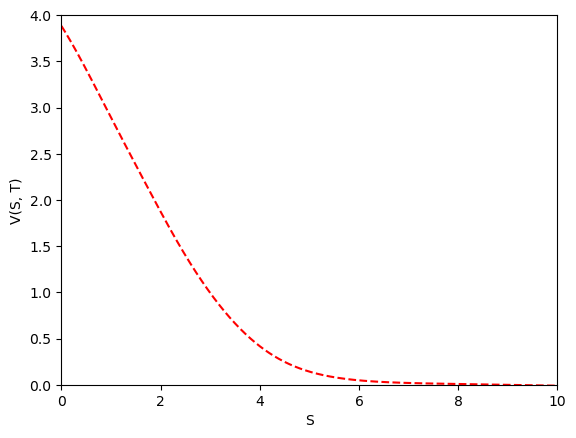

In [32]:
# plt.plot(X[final_index, 0], y_pred[final_index], '--', color="r")
plt.plot(x_right_test.cpu().detach().numpy(), pred_right, '--', color="r")

# plt.figure()
plt.xlabel('S')
plt.ylabel('V(S, T)')
# set the limits
plt.xlim([0, 10])
plt.ylim([0, 4])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

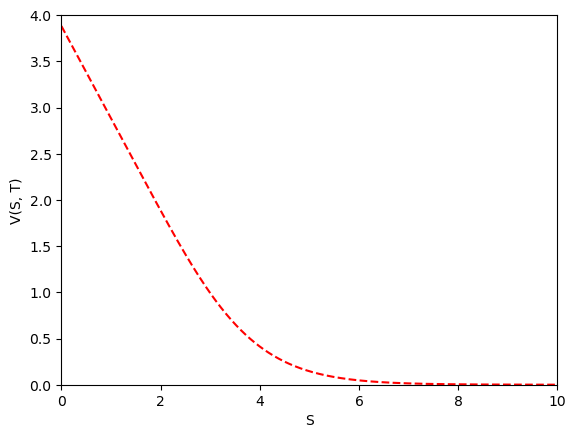

In [34]:
# plt.plot(X[final_index, 0], y_pred[final_index], '--', color="r")
plt.plot(b_right_test[:,0], u_right, '--', color="r")

# plt.figure()
plt.xlabel('S')
plt.ylabel('V(S, T)')
# set the limits
plt.xlim([0, 10])
plt.ylim([0, 4])
plt.show

# Another Approach

In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as tgrad
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as si

def black_scholes_call_div(X, K, r, sigma):
    T = X[:, 0]
    S = X[:, 1]

    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

    call = (S*si.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*T)*si.norm.cdf(d2, 0.0, 1.0))
    return call

def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1))
    return X, y

def get_evp_data(n):
    X = np.concatenate([np.ones((n, 1)),
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)

    return X, y

def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))

    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = black_scholes_call_div(X2, K, r, sigma).reshape(-1, 1)
    # y2 = np.array([black_scholes_call_div(X, K, T, r, sigma) for (T, X) in X2]).reshape(-1, 1)
    # y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)

    return X1, y1, X2, y2

K = 40              # Strike Price
r = 0.05            # Interest Rate
sigma = 0.25        # Annual volatility of asset
T = 1               # Time to maturity
S_range = [0, 500]  # Input ranges for asset price
t_range = [0, T]    # Input ranges for time
gs = lambda x: np.fmax(x - K, 0)  # Instrinsic value of call option

device = "cpu"

In [127]:
X1, y1 = get_diff_data(10)

get_evp_data(10)

(array([[  1.        ,  35.43488909],
        [  1.        , 146.39701572],
        [  1.        ,  76.17735284],
        [  1.        , 208.7431874 ],
        [  1.        ,  65.64466424],
        [  1.        , 302.05890201],
        [  1.        , 191.40402958],
        [  1.        , 447.69294214],
        [  1.        , 483.8973359 ],
        [  1.        , 273.44245083]]),
 array([[  0.        ],
        [106.39701572],
        [ 36.17735284],
        [168.7431874 ],
        [ 25.64466424],
        [262.05890201],
        [151.40402958],
        [407.69294214],
        [443.8973359 ],
        [233.44245083]]))

In [126]:
X1

array([[9.74256213e-01, 1.20709310e+02],
       [9.90345002e-01, 3.31252286e+02],
       [4.09054095e-01, 1.23031592e+02],
       [1.62954426e-01, 3.32929559e+02],
       [6.38761757e-01, 2.58654259e+02],
       [4.90305347e-01, 2.12044494e+02],
       [9.89409777e-01, 2.77343904e+02],
       [6.53042072e-02, 1.43525760e+02],
       [7.83234438e-01, 3.53287353e+02],
       [2.88398497e-01, 2.07428435e+02]])

In [ ]:
model = PINNs(2, 128, 1, 6)